# 📎RNN using IMDB Datasets

## PyTorch

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/5, Train Acc: 0.5850, Val Acc: 0.5859
Epoch 2/5, Train Acc: 0.6163, Val Acc: 0.6261
Epoch 3/5, Train Acc: 0.6884, Val Acc: 0.6351
Epoch 4/5, Train Acc: 0.7434, Val Acc: 0.7109
Epoch 5/5, Train Acc: 0.7482, Val Acc: 0.7354

Evaluation Metrics:
Accuracy : 0.7354
Precision: 0.7238
Recall   : 0.7612
F1-Score : 0.7421
AUC      : 0.8058


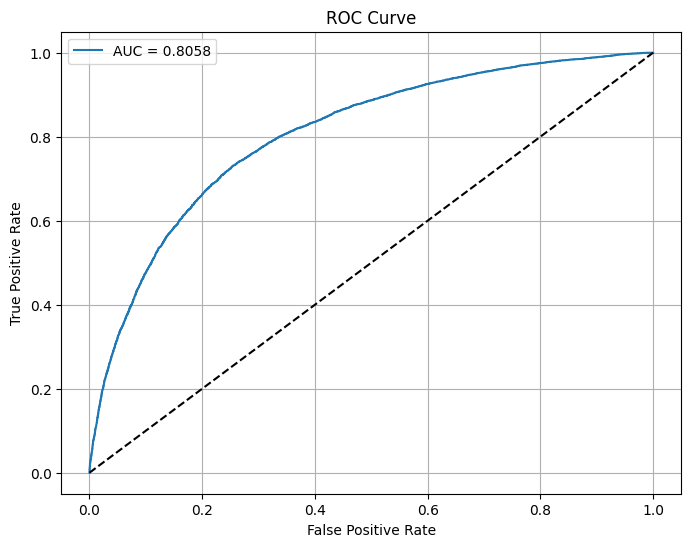

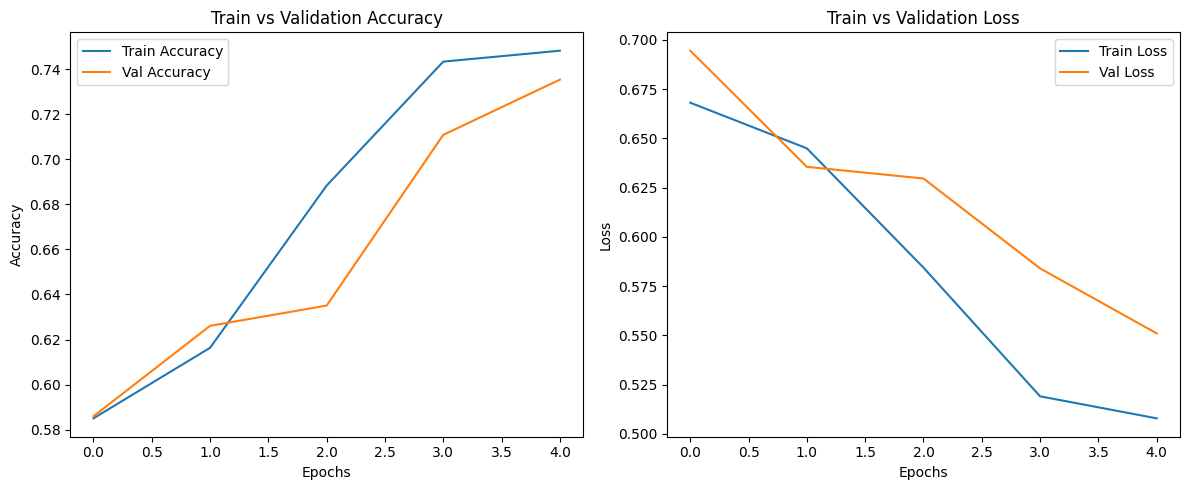

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_words = 30000
maxlen = 300
batch_size = 64
embedding_dim = 128
hidden_dim = 128
num_epochs = 5

# Load IMDB dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

x_test_tensor = torch.tensor(x_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define vanilla RNN model
class VanillaRNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(VanillaRNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.embedding(x)  # (batch, seq, embed)
        out, hn = self.rnn(x)  # hn: (1, batch, hidden)
        hn = hn.squeeze(0)     # (batch, hidden)
        out = self.fc(hn)      # (batch, 1)
        return torch.sigmoid(out).squeeze(1)

# Instantiate model
model = VanillaRNNModel(num_words, embedding_dim, hidden_dim).to(device)

# Loss & optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_accs.append(correct / total)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item()
            preds = (outputs > 0.5).float()
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)

    val_losses.append(val_loss / len(test_loader))
    val_accs.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Acc: {train_accs[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}")

# Evaluation
model.eval()
all_preds, all_probs, all_targets = [], [], []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        probs = outputs.cpu().numpy()
        preds = (outputs > 0.5).float().cpu().numpy()
        all_probs.extend(probs)
        all_preds.extend(preds)
        all_targets.extend(y_batch.numpy())

# Metrics
accuracy = accuracy_score(all_targets, all_preds)
precision = precision_score(all_targets, all_preds)
recall = recall_score(all_targets, all_preds)
f1 = f1_score(all_targets, all_preds)
auc = roc_auc_score(all_targets, all_probs)
fpr, tpr, _ = roc_curve(all_targets, all_probs)

print("\nEvaluation Metrics:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy & Loss plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()


## TensorFlow

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 110s 272ms/step - accuracy: 0.5887 - loss: 0.6532 - val_accuracy: 0.7831 - val_loss: 0.4770
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 105s 269ms/step - accuracy: 0.8066 - loss: 0.4360 - val_accuracy: 0.7746 - val_loss: 0.4864
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 105s 269ms/step - accuracy: 0.8249 - loss: 0.3977 - val_accuracy: 0.6916 - val_loss: 0.5839
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 138s 259ms/step - accuracy: 0.8139 - loss: 0.4174 - val_accuracy: 0.7652 - val_loss: 0.5145
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 146s 269ms/step - accuracy: 0.7972 - loss: 0.4350 - val_accuracy: 0.7321 - val_loss: 0.5479
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step

Evaluation Metrics:
Accuracy : 0.7321
Precision: 0.7333
Recall   : 0.7295
F1-Score : 0.7314
AUC      : 0.8057


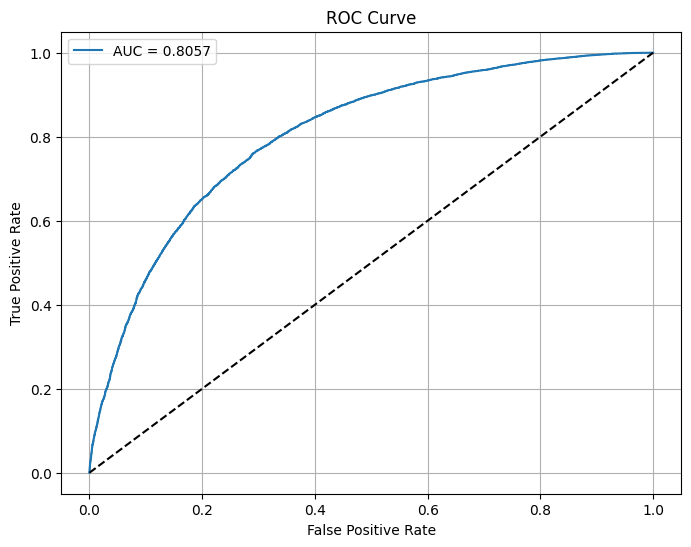

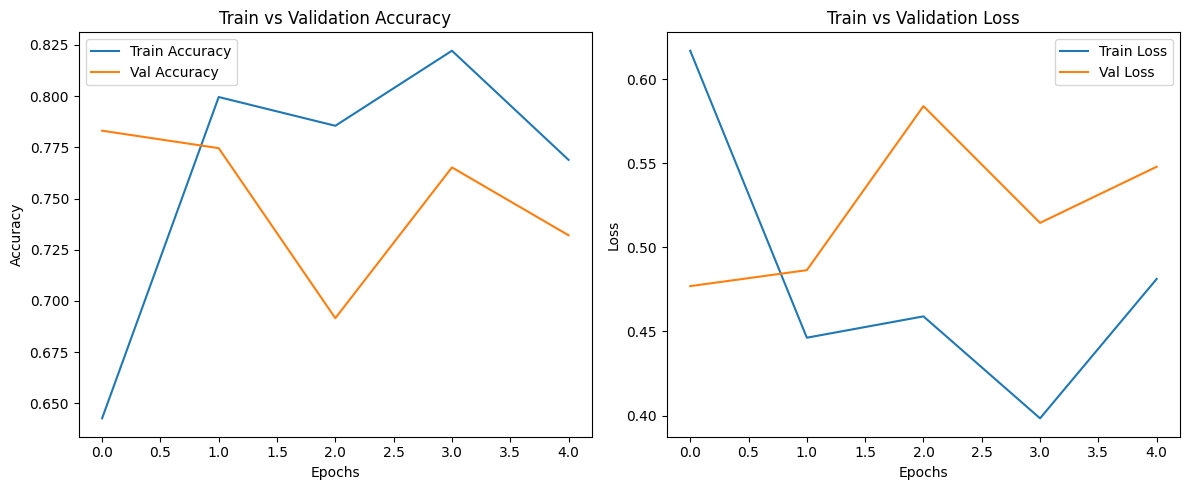

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import History

# Hyperparameters
num_words = 30000
maxlen = 300
batch_size = 64
embedding_dim = 128
hidden_dim = 128
num_epochs = 5

# Load and preprocess dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

# Build model using vanilla RNN (SimpleRNN)
model = Sequential([
    Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=maxlen),
    SimpleRNN(hidden_dim, activation='tanh'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(x_test, y_test)
)

# Evaluation
y_prob = model.predict(x_test).flatten()
y_pred = (y_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

print("\nEvaluation Metrics:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy & Loss plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()
